### 1. Reading dataset and pre-processing

Assignment Dataset
In this Assignment we Read data from the **COVID-19 Open Research Dataset Challenge (CORD-19)** available in https://www.kaggle.com/datasets/allen-institute-for-ai/CORD-19-research-challenge.From which we subsample over 1,000,000 scholarly articles, including over 400,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. to get 10,000 random articles which are considered as dataset and used to create a factoid based question answering system that can find relevant article snippets matching a simple fact-based query in natural language.



The Data subsampling and reading can be found submitted Data.ipynb this file was run as a kaggle notebook on kaggle server to randomly select 10,000 articles. which were then exported as csv into covid_articles.csv. We extract
* paper_id
* body_text
* authors
* title
* abstract
 <br />and use these to create a simple factoid based question answering system.

In [ ]:
# from gensim.models import Word2Vec

In [ ]:
# Import Libraries
import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!pip install spacy_fastlang
!pip install transformers
!pip install SentencePiece
!pip install datasets
!pip install evaluate
!pip install rouge-score
import torch
import numpy as np
import pandas as pd
import string
import re
import textwrap
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords #Importing Stop Words
#Tokenize the words
nltk.download('punkt')
from nltk.tokenize import word_tokenize #to TOkenize the words
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


import spacy
from spacy import displacy
from tqdm import tqdm
import spacy_fastlang

import os
import re
import time
# !pip install --upgrade gensim
from gensim.models import Word2Vec
from tqdm import tqdm

tqdm.pandas()

from datasets import load_metric
metric = load_metric("rouge")

import pprint
import pickle 
# !python -m spacy download en_core_web_md
# !pip install -U spacy[cuda92]
# !pip install spacy-language-detection
# !pip install spacy_fastlang
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/NLP/Ass3/'

# #Reading the Dataset
# # article_df = pd.read_csv(data_dir + 'md_pmc_covid_articles.csv')
# article_df = pd.read_csv(data_dir + 'pmc_covid_articles.csv')
# #removing repeated index column
# article_df = article_df.drop(['Unnamed: 0'], axis=1)
# # # # article_df.head(5)
# proc_article_df = pd.read_csv(data_dir + 'Processed_covid_articles.csv')
# #removing repeated index column
# proc_article_df = proc_article_df.drop(['Unnamed: 0'], axis=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-3364f6825f34>:46: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset was filtered and 10,000 articles were extracted using kaggle notebook which can be found at : https://www.kaggle.com/code/neilanu1702/nlp-covid19-preprocess-neil

In [ ]:
#Reading the Dataset
article_df = pd.read_csv(data_dir + 'pmc_covid_articles.csv')
#removing repeated index column
article_df = article_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
# !pip install spacy_fastlang
# import spacy_fastlang
lang_detect = spacy.load("en_core_web_sm")
lang_detect.add_pipe('language_detector')

In [ ]:
article_df.head()

,paper_id,body_text,authors,title,abstract
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...


In [ ]:
#Detecting Articles of different Languages in our Datset
article_df['Language'] = [lang_detect(i)._.language for i in article_df['title']]
print(article_df['Language'].unique())

['en' 'lv' 'es' 'de' 'fr' 'cs' 'zh' 'lt' 'nl' 'it' 'pt' 'oc' 'id' 'sl'
 'th' 'ms' 'ar' 'fi' 'ca' 'ja' 'la' 'sr' 'pl']


In [ ]:
#Filtering and considering only english articles 
fltr_article_df = article_df[article_df['Language'] == 'en']
print(fltr_article_df['Language'].unique())

['en']


In [ ]:
fltr_article_df.head()

,paper_id,body_text,authors,title,abstract,Language
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...,en
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...,en
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...,en
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...,en
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...,en


In [ ]:
#Now Considering only 4500 articles for our system
fltr_article_df = fltr_article_df[0:4500]

In [ ]:
fltr_article_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4614
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   4500 non-null   object
 1   body_text  4500 non-null   object
 2   authors    4500 non-null   object
 3   title      4500 non-null   object
 4   abstract   4500 non-null   object
 5   Language   4500 non-null   object
dtypes: object(6)
memory usage: 246.1+ KB


#### Exploring the Processed Data
Upon exploring the unique words in our processed Body text for 10,000 articles we found 'et','al','1','2' as highly freqeunt , BUt these words can be considered as noise since they porvide no informational value, to remove these Stop words was updated to include and filter these<br/>
Most frequent word as appearing in the articles is 'patient'.

In [ ]:
def preprocess(text,flag=0):

    # define regular expressions for common citation styles
    apa_regex = r"\(\d{4}\)"
    mla_regex = r"\(\w+\s\d+\)"
    ieee_regex = r"\[\d+\]"

    # define a regular expression to match references
    ref_regex = r"\[\d+\]"

    #Remove punctuation and all non-alphanumaric characters
    remove = string.punctuation.replace('.', '')
    rm_punct = [line.translate(line.maketrans('', '', remove)) for line in text]

    # remove APA-style citations
    text = [re.sub(apa_regex, "", i)for i in rm_punct]

    # remove MLA-style citations
    text = [re.sub(mla_regex, "", i)for i in text]

    # remove IEEE-style citations
    text = [re.sub(ieee_regex, "", i)for i in text]

    # remove references
    text = [re.sub(ref_regex, "", i)for i in text]

    # Tokenize the sentences
    token_words = [word_tokenize(j) for j in text]

    # #Remove all non-alphanumaric characters
    # rm_nonalpha = [[re.sub(r'[^a-zA-Z0-9]','',i)for i in line ] for line in token_words]

    #Remove Stop words
   #  stop_words = set(stopwords.words('english'))
    custom_stop_words = ['et','al','"','’','“','”','usepackageamsfonts','usepackageamssymb','usepackageamsmath','usepackagewasysym',
 'usepackageamsbsy','usepackagemathrsfs','usepackageupgreek','setlengthoddsidemargin69pt']
    stop_words = set(stopwords.words('english') + custom_stop_words)
    
    rm_stp  = [[word for word in line if word.lower() not in stop_words]for line in token_words]

    #Performing Lemmatization and lowering of words
    text_ver3 = [[lemmatizer.lemmatize(word.lower()) for word in line]for line in rm_stp]

    #Reconstructing into sentences
    text_ver1 = [" ".join(word) for word in text_ver3 if word != '']

    return text_ver1

In [ ]:
#Processing the Body_text and titles from the sampeled 

#Creating a new Dataframe with processed body and title 
proc_article_df = fltr_article_df.copy()
proc_article_df['body_text'] = proc_bdy
proc_article_df.head()

#Storing the Datframe for later use
# proc_article_df.to_csv("Processed_covid_articles.csv")
#Reading form Dataframe to save time
# proc_article_df = pd.read_csv('Processed_covid_articles.csv')
#removing repeated index column
# proc_article_df = proc_article_df.drop(['Unnamed: 0'], axis=1)

,paper_id,body_text,authors,title,abstract,Language
0,PMC8524215,cancer prevalent cause mortality world common ...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,68591 One of the most common gynecologic ca...,en
1,PMC7698314,sarscov2 virus responsible covid19 disease fir...,"['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,813557 ED-visits and through-ED admissions ...,en
2,PMC8050998,artificial intelligence ai methodology compute...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,757155 Artificial intelligence (AI) is a br...,en
3,PMC7581283,common feature patient admitted coronavirus di...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,942009 INTRODUCTION: Patients with coronavi...,en
4,PMC7392455,coronavirus disease covid19 caused severe acut...,"['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,843714 We report 3 patients with coronaviru...,en


In [ ]:
article_df.head()

,paper_id,body_text,authors,title,abstract
0,PMC8524215,Cancer is the most prevalent cause of mortalit...,"['Muhammad Sufyan ', 'Farah Shahid ', 'Faiza...",Implementation of Vaccinomics and In-Silico Ap...,One of the most common gynecologic cancers is ...
1,PMC7698314,"SARS-CoV-2, the virus responsible for COVID-19...","['Enrique Casalino ', 'Christophe Choquet ',...",Analysis of Emergency Department Visits and Ho...,ED-visits and through-ED admissions to medical...
2,PMC8050998,Artificial intelligence (AI) is a methodology ...,"['Martina Gurgitano ', 'Salvatore Alessio Ang...",Interventional Radiology ex-machina: impact of...,Artificial intelligence (AI) is a branch of In...
3,PMC7581283,A common feature of most patients admitted wit...,"['Ejvind Frausing Hansen ', 'Charlotte Sandau ...",Automatic oxygen titration with O2matic® to pa...,INTRODUCTION: Patients with coronavirus diseas...
4,PMC7392455,"Coronavirus disease (COVID-19), caused by seve...","['Daniel O. Griffin ', 'Alexandra Jensen ', '...",Pulmonary Embolism and Increased Levels of d-D...,We report 3 patients with coronavirus disease ...


####  Pre-processing the Data

* To process the data we remove citations and references
* Using the reference provided below the Punctuation, Stop words were removed and words were Lemmatized.<br/>
* Instead of keeping text as Bag of Words (BOW) the word tokens were then rejoined to form a single string representing the entire body text to reduce processing time for the text.<br/>
* The above mentioned pre- processing steps are done in order to reduce the noise in the data and help us during the Named Entity Recognition part of the project, cleaning and processing the text helps in reducing time required for processing ad helps in reducing noise in the data. <br/>

In [ ]:
#Showing Unique words in Processed Body text in all of articles
def unique_dict(data):
  uniqe_version = {}
  for line in data:
    split_ln  = line.split()
    for j in split_ln :  
      if j in uniqe_version.keys():
          uniqe_version [ j ] += 1
      else :
          uniqe_version [ j ] = 1
  return uniqe_version

total_uniq_words = unique_dict(proc_article_df['body_text'])


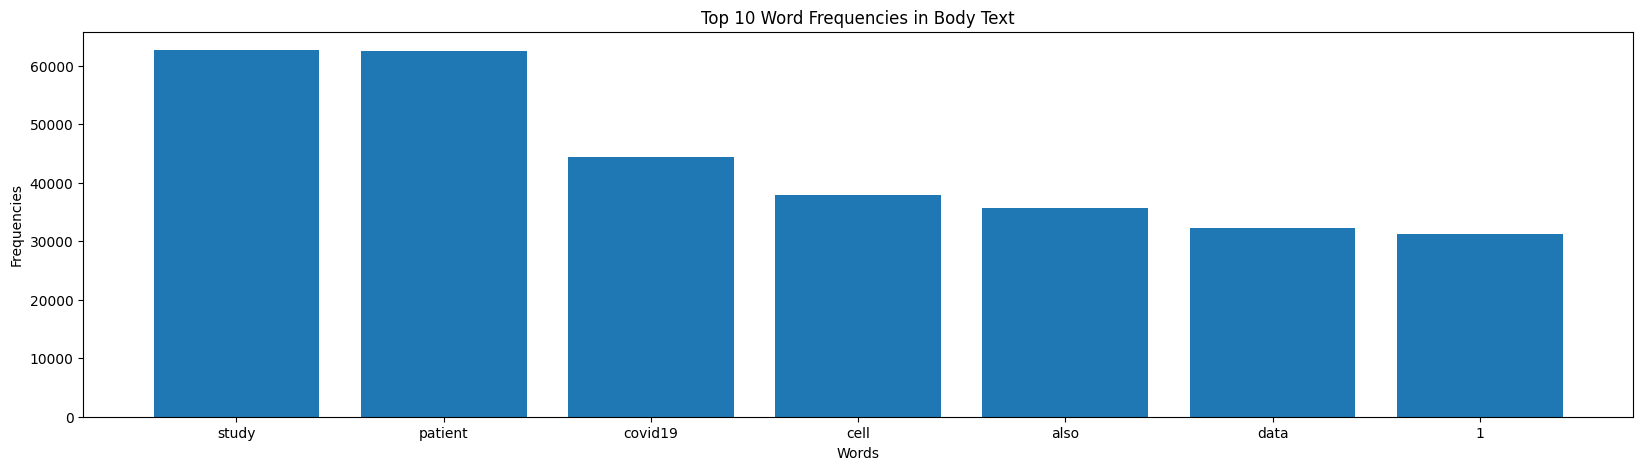

<Figure size 640x480 with 0 Axes>

In [ ]:
# Sort the dictionary by frequency in descending order
sorted_dict = {k: v for k, v in sorted(total_uniq_words.items(), key=lambda item: item[1], reverse=True)}

# Extract the top 10 frequencies
top_freq = [freq for word, freq in list(sorted_dict.items())[1:8]]

# Extract the top 10 words
top_words = [word for word, freq in list(sorted_dict.items())[1:8]]

# Plot a bar chart of the top 10 frequencies
plt.figure(figsize=(20,5))
plt.bar(top_words, top_freq)
plt.title('Top 10 Word Frequencies in Body Text')
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.show()
plt.savefig('Uniq_words.png')

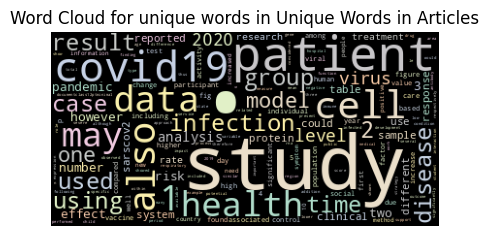

In [ ]:

#Word Cloud for unique words any dataset
def disp_wordCloud(title,dict,max_words=1000):
  plt.figure(figsize=(5,6))
  wordcloud = WordCloud (background_color="black",max_words=1000).generate_from_frequencies (dict)
  plt.imshow ( wordcloud , interpolation= 'bilinear' ) 
  plt.axis ( "off" ) 
  plt.title ( f"Word Cloud for unique words in {title}" ) 
  plt.imshow (wordcloud.recolor(colormap='Pastel2', random_state=17), alpha=0.98)

title = "Unique Words in Articles"
disp_wordCloud(title,sorted_dict,max_words=1000)

### 2. Named Entity Recognition and Knowledge Base

#### Knowledge Base

**Knowledge Base** is a structured database that contains a collection of facts in the form <subject, relation, object> , where each fact can have properties attached called qualifiers.

* ReVerb is a program that automatically identifies and extracts binary relationships from English sentences.Using reverb to create a KB extracting Entities and their relations from body text of articles and storing them into a tuple.

* The KB formed here will be used in the latter stages to filter the articles to find articles relevant to the query asked by the user.

In [ ]:
#Combining the pre_proc body text and storing into a file for input to Reverb
# all_text = " ".join(proc_article_df['body_text'])
# path = data_dir + 'Reverb_Prod_data.txt'
# with open(path, 'w') as f:
#     f.write(all_text)
#     f.close()

#Run Reverb on the Processed BOdy text for 5000 articles
# !java -Xmx512m -jar reverb-latest.jar Reverb_Prod_data.txt >> Reverb_input_5000.txt 

In [ ]:
'''
Function to parse thoough reverb output to extract entity and relations
and storing the output in (Entity1,Relation,Entity2) format 
'''
path = data_dir + 'Reverb_input_5000.txt'
def extract_entity_relations(filepath=path):
    all_relations = []
    entity1 = []
    entity2 = []
    with open(filepath, 'r',encoding='latin') as f:
        x = [line.strip() for line in f.readlines()]
    f.close()
    for i in x:
        i = i.split('\t')
        entity1.append(i[-3])
        entity2.append(i[-1])
        all_relations.append((i[-3].replace("#", "").strip(),i[-2].replace("#", "").strip(),i[-1].replace("#", "").strip()))
    return all_relations,entity1,entity2

In [ ]:
import spacy
import matplotlib.pylab as plt
import networkx as nx

all_relations,entity1,entity2 = extract_entity_relations()

# Display Knowledge graph/knowledge base for 5 different entities
# Show a maximum of 3 relations per entity
total = 4
count = 0
print("Entity 1", "<--", "Relation", "-->", "Entity 2")
print("----------------------------------------------")
for entities in all_relations[0:10]:
    print(entities[0], "<--", entities[1], "-->", entities[2])



Entity 1 <-- Relation --> Entity 2
----------------------------------------------
exercise classified resistance flexibility <-- endurance --> balance etc
pandemic outbreak fear anxiety <-- spread across --> population germany
pandemic <-- result --> death worldwide
first evolution model cov proposed bat covs <-- serve --> gene source covs
 <-- cause --> common cold infection
common cold infection <-- lead --> acute lower respiratory tract infection exacerbate chronic pulmonary disease asthma
novel coronavirus ncov <-- emerge --> huanan wet food market livestock animal
herd immunity overall simulation pandemic <-- depend --> efficacy time course immunity
morbidity mortality <-- vary across --> country world
state <-- confirm --> case  death india


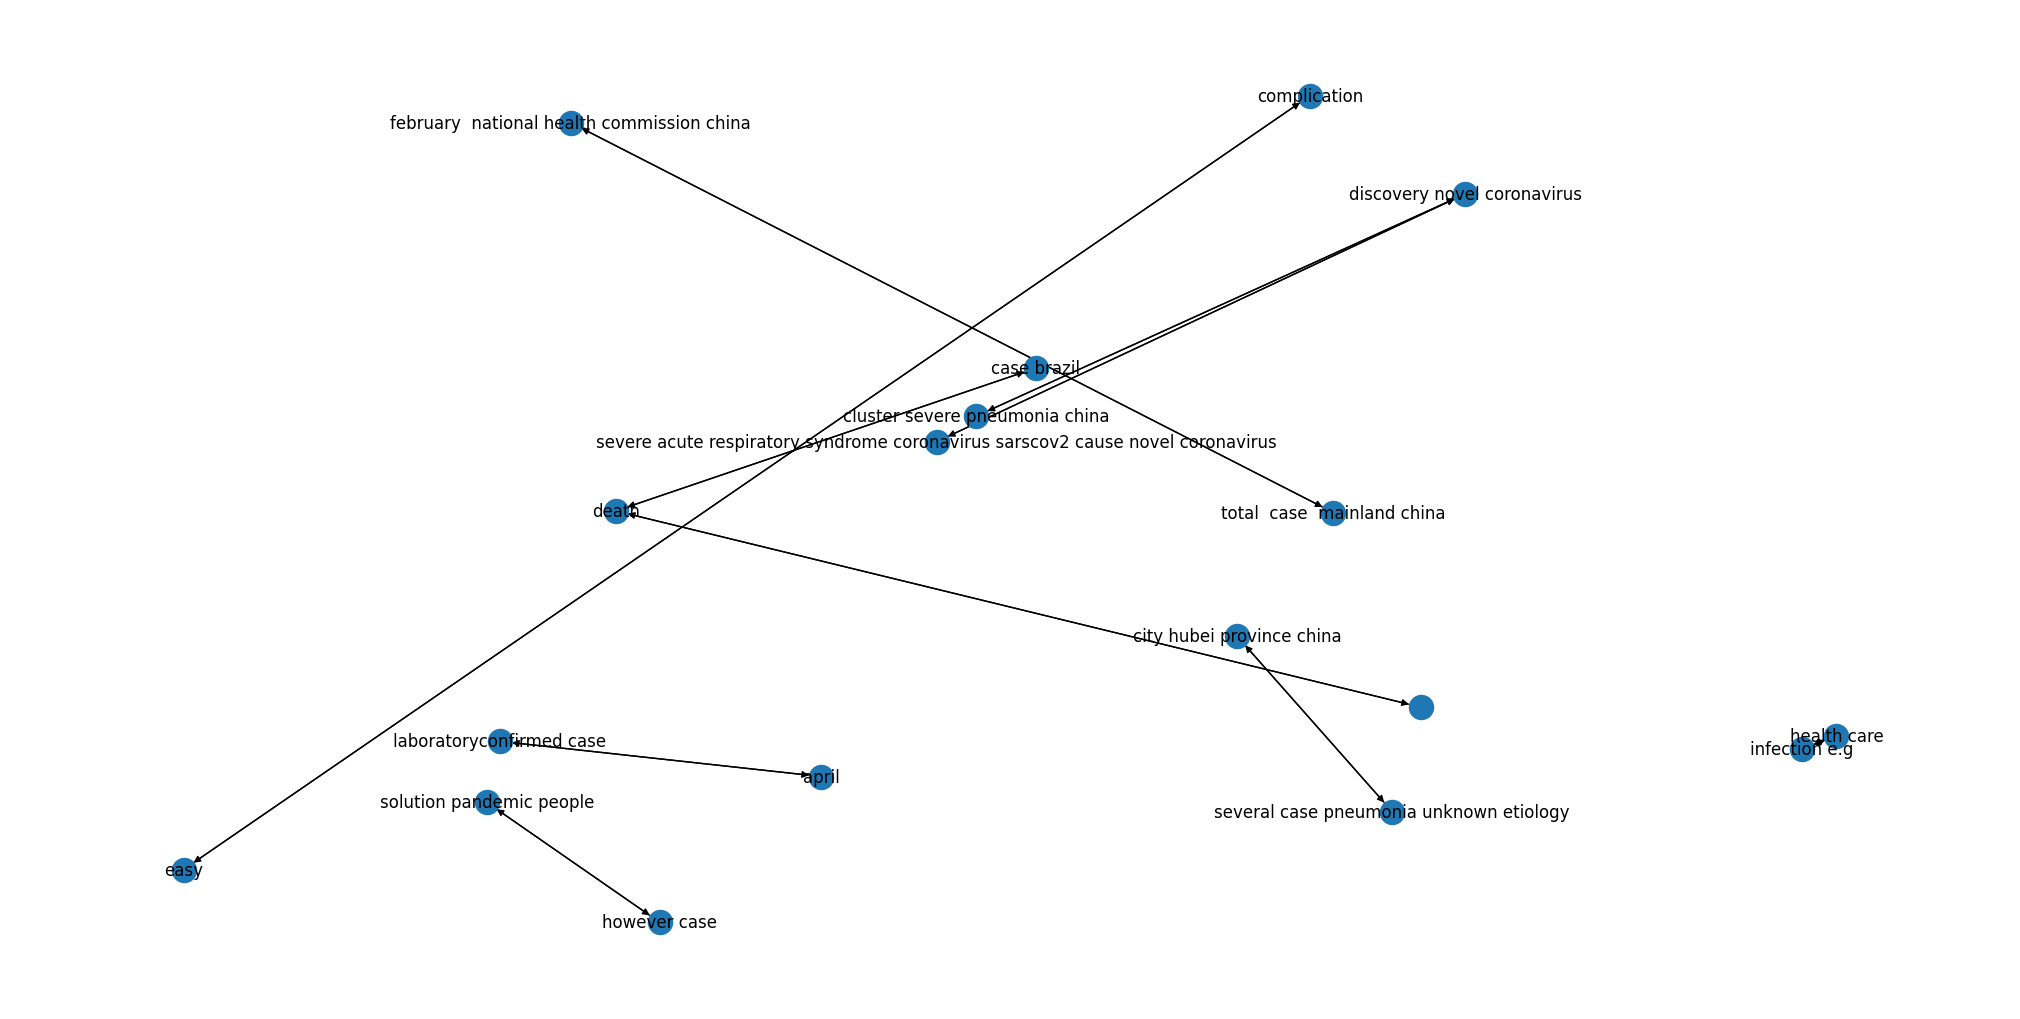

In [ ]:
'''
Function to visualize the Knowledge base
'''
def mk_Graph(ent_ls):

    # Create a directed graph
    G = nx.DiGraph()
    for i in ent_ls:

        # Add edges to the graph
        G.add_edge(i[0], i[2])
        G.add_edge(i[2], i[0])
    # Visualize the graph in the notebook
    plt.figure(figsize=(20, 10))
    # nx.draw_random(knowledge_graph_display, with_labels=True)
    nx.draw_random( G , with_labels=True)

#Displaying 10 entiry relationship pairs 
mk_Graph(all_relations[20:30])

In [ ]:
'''
Since entities recognized by reverb may not necessarily be the same as those recognized by spacy
thus manually creating a KB to be utilized in text matching utility to also include articles mentioning associated names of entities on a smaller subset of data
'''
kb = {
    "covid19": ["covid","corona","coronavirus","COVID-19","coronavirus",
                "33increases282.529sarscov2", "covid19","postcovid19","africa3456789101112covid1915syndrome","11covid19","16covid19 ","covid1922517","china2 covid19","43.4covid19","spo2covid19","coronavirus influenza","coronavirus international committee", "coronavirus jev","50covid19","daycovid19","carecovid19","daysarscov2","daycovid19", "marchcovid19","coronavirus10","coronavirus1114","coronavirus12","coronavirus13","coronavirus14","coronavirus16","coronavirus17 20 agent","coronavirus19","coronavirus19  ahorsu","coronavirus19 134","coronavirus19 5point","coronavirus19 covid19","coronavirus19 pandemic acute","coronavirus2","coronavirus2 sarscov2","sarscov2","coronavirus20","coronavirus2019" ,"covid19", "coronavirus2019 sarscov2" ,"coronavirus4 sarscov2", "anywhere3334covid","corona2020","corona353637covid19","coronaviruscovid19" ],
    "facemask": ["face","mask","face masks","facemask", "facemask day", "facemask1.8–4.4","masks10","masks10 11", "masks19","masksmg","masks22","masks23","masks26 tokyo","masks27","masks3" ,"mask94.0","mask5.5","masks39","masks4","masks45","masks7","masks8","maskaround" ],
    "south africa": ["south africa","africa shown","africa small","africa smart","africa smith","africa somalia","africa south africa","africa south african","africa south america","africa south asia" ,"africa study","africa tanzania","africa thailand","africa time","africa tropic","africa turkey","africa uganda", "africa union","south african"]
}
# kb = {
#     "covid19": ["covid","corona","coronavirus","COVID-19","coronavirus", "covid19","daycovid19", "marchcovid19","coronavirus10","coronavirus1114","coronavirus12","coronavirus13","coronavirus14","coronavirus16","coronavirus2","sars","sarscov2","coronavirus20","coronavirus2019" ,"covid19", "sarscov2" ,"coronavirus4 sarscov2", "anywhere3334covid","corona2020" ],
#     "facemask": ["face","mask","face masks","facemask", "facemask day", "facemask1.8–4.4","masks10","masks10 11", "masks19","masksmg","masks22","masks23","masks26 tokyo","masks27","masks3" ,"mask94.0","mask5.5","masks39","masks4","masks45","masks7","masks8","maskaround" ],
#     "south africa": ["south africa","africa shown","africa small","africa smart","africa smith","africa somalia","africa south africa","africa south african","africa south america","africa south asia" ,"africa study","africa tanzania","africa thailand","africa time","africa tropic","africa turkey","africa uganda", "africa union","south african"]
# }

### Indexing method

Implementing Inverted Index method as mentined in 14.1.3 of Jurafsky’s textbook.For this method

* Read processed body text from articles 
* Using spacy to identify all entities in the body text and keeping a record on the paper_id'd they appear in
* Doing the above for all articles to create an inverted index containing entity as key and paper's it appears in as id.

Inverted index is created to reduce the number of articles considered when checking cosine similarity with the query, it helps in filtering the articles to only consider those which have the entity present in the query contained within.

In [ ]:
# Function to create an inverted index which keeps a track of entity and the papers it appears in 
def New_Inverted_idx(data):
    KB_df = {}
    uniq_ents = {}
    uniq_paper = {}
    for i,line in enumerate(tqdm(data)):
        chunks = chunk_strings([line])
        for ch_line in chunks:
            doc = nlp(ch_line)
            for word in doc.ents:
                if (word.text in uniq_ents.keys() and i in uniq_paper.keys()):
                    pass
                else:
                    uniq_ents[word.text] = 0
                    uniq_paper[i] = 0
                    if word.text in KB_df.keys():
                        KB_df [word.text].append(i)
                    else :
                        KB_df [word.text] = [i]
    return KB_df
# new_inv_idx = New_Inverted_idx(proc_article_df['body_text'])
# new_inv_idx

In [ ]:
#Exporting the created inverted index as a json file to save computational time
import json
# Writing to from Json file
# with open('Bdy_inv_idx.json', 'w') as fp:
#     json.dump(new_inv_idx, fp)
# # Reading from Json file
with open(data_dir +'Bdy_inv_idx.json') as f:
    new_inv_idx = json.load(f)

In [ ]:
def indexing_method(data_dict,paper_ids):
    inverted_index = []
    for key,value in data_dict.items():
        inverted_index.append((key,len(value),[paper_ids[i]for i in value]))
    inverted_df = pd.DataFrame(inverted_index, columns=['entity', 'Frequency', 'Papers'])
    return inverted_df

In [ ]:
print("Inverted Index for Body text")
#Displaying the first 10 entries of inverted index in a Dataframe
disp_inv_index = sliced_dict = dict(list(new_inv_idx.items())[200:220])
indexing_method(disp_inv_index,article_df['paper_id'])

Inverted Index for Body text


,entity,Frequency,Papers
0,789101112,1,[PMC7698314]
1,covid19,313,"[PMC7698314, PMC7392455, PMC7426871, PMC748106..."
2,15,6,"[PMC7698314, PMC7406824, PMC7431399, PMC854070..."
3,syndrome 16,1,[PMC7698314]
4,covid19 europe,1,[PMC7698314]
5,france,3,"[PMC7698314, PMC8995928, PMC7970000]"
6,17,3,"[PMC7698314, PMC8147939, PMC8003209]"
7,winter,1,[PMC7698314]
8,previous season,1,[PMC7698314]
9,18,3,"[PMC7698314, PMC8159131, PMC8597969]"


In [ ]:
# geting most frequent words from the inverted index
def get_top_n_words(word_frequency, n):
    word_frequency_list = [{'word': k, 'count': v} for k, v in word_frequency.items()]
    word_frequency_df = pd.DataFrame(word_frequency_list)
    word_frequency_df_sorted = word_frequency_df.sort_values(by=["count"], ascending=False)
    return word_frequency_df_sorted.head(n)

In [ ]:
# most frequent words in body text inverted index. It seems that the most common words are the alphabetic representations of the number
get_top_n_words(new_inv_idx, 10)

,word,count
179115,university alberta human research ethic committee,[4499]
179110,≥ 1 presumed,[4499]
179106,intracranial hemorrhagic complication,[4499]
179108,lixiana,[4499]
179109,early ≤5 day,[4499]
179107,early 7 day 30 day,[4499]
179111,30–50 ml,[4499]
179112,prior edoxaban,[4499]
179113,100 4 95,[4499]
179114,14 january 2021,[4499]


#### Trying Custom word vector Models

##### Spacy vectors training

In [ ]:
# Ref : https://www.kaggle.com/code/chewzy/tutorial-how-to-train-your-custom-word-embedding
# Parameters reference : https://www.quora.com/How-do-I-determine-Word2Vec-parameters

train_sentences = "".join(proc_article_df['body_text'])
start_time = time.time()

model = Word2Vec(sentences=train_sentences,sg=1,vector_size=100, workers=4)

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 5.94 mins


In [ ]:
# #Saving the Model
# model.wv.save_word2vec_format('custom_glove_100d.txt')

# from gensim.models import KeyedVectors
# # How to load:
# model = KeyedVectors.load_word2vec_format(data_dir +'custom_glove_100d.txt')

# # How to get vector using loaded model
# # w2v.get_vector('iphone')

In [ ]:
def compute_custom_vectors(documents):
    # this model stores all the precomputed vectors
    # model.wv
    document_custom_vectors = {}
    file_counter = 0
    row_count = 0
    # batch_size = 1000
    for index, row in tqdm(documents.iterrows(), total=documents.shape[0]):
        paper_id = row['paper_id']
        document = row['body_text']
        # Preprocess the text
        tokens = word_tokenize(document)
         # Get the vectors for each word in the text
        vectors = [model.wv.get_vector(token) for token in tokens if token in model.wv]
        # Average the vectors to get a single vector for the article
        if vectors:
            vector = np.mean(vectors, axis=0)
        else:
            vector = np.zeros((model.vector_size,))
        # doc_vector = model.wv.get_vector(vector)
        document_custom_vectors[paper_id] = vector

    return document_custom_vectors

In [ ]:
document_custom_vectors = compute_custom_vectors(proc_article_df)
len(document_custom_vectors)

100%|██████████| 4500/4500 [01:24<00:00, 53.23it/s]


4500

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")
# object to hold pre-trained spacy model - en_core_web_md
text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
def compute_spacy_document_vectors(documents, text_vectorizer):
    # this stores all the precomputed vectors
    document_spacy_vectors = {}
    # mapping for paper_id and filename for efficient lookup of records
    paper_id_file_counter_mapping = {}
    file_counter = 0
    row_count = 0
    # batch_size = 1000
    for index, row in tqdm(documents.iterrows(), total=documents.shape[0]):
        row_count += 1
        paper_id = row['paper_id']
        document = row['body_text']
        doc_vector = text_vectorizer(document)
        document_spacy_vectors[paper_id] = doc_vector

    return document_spacy_vectors


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
document_spacy_vectors = compute_spacy_document_vectors(proc_article_df, text_vectorizer)
len(document_spacy_vectors)

100%|██████████| 4500/4500 [05:33<00:00, 13.51it/s]


4500

In [ ]:
# article_df.head()


4500

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#Triggering GPU utilization for spacy
spacy.prefer_gpu()
# Load the English language model
nlp=spacy.load('en_core_web_sm')


#Create chunks of 100,000 characters so we dont exceed spcaey's limit
def chunk_strings(lst,chunk_size = 1000000):
    result = []
    for string in lst:
        if len(string) > chunk_size:
            chunks = [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]
            for j in chunks:
                result.append(j)
        else:
            result.append(string)
    return result

class textmatch:

    def __init__(self):
        self.kb = kb
        self.inv_idx = new_inv_idx
        self.unprocessed_data = article_df
        self.body_preprocess = False
        # Creating a flag to trigger use of cosine similarity or spacy word vectors
        self.cos = 1

    #Function to  return a list of relevant articles based on query given by user itilizing inverted index and KB
    def Inv_idx_text(self,query,kb = kb):
        relevant_articles = []
        uniq_relevant_articles = set()
        inv_dict = self.inv_idx
        Candidate_entities = []

        # # If use KB flag is set searcing KB for assiciate names 
        # if self.ner_kb:
        for candicate_key in kb:
            for query_ent in query:
                if (query_ent in kb[candicate_key]):
                    # List to store related entities                   
                    Candidate_entities.extend(kb[candicate_key])
        Candidate_entities = list(set(Candidate_entities))
        overall_ent = []
        for ent in range(len(all_relations)):
            for q_ent in query:
                if q_ent in all_relations[ent][0]:
                    # print(entity1[ent], "<--", all_relations[ent][1], "-->", entity2[ent])
                    overall_ent.append(all_relations[ent][0])
                    overall_ent.append(all_relations[ent][2])
                elif q_ent in all_relations[ent][2]:
                    # print(entity1[ent], "<--", all_relations[ent][1], "-->", entity2[ent])
                    overall_ent.append(all_relations[ent][0])
                    overall_ent.append(all_relations[ent][2])
        overall_ent = list(set(overall_ent))
        Candidate_entities.extend(overall_ent)
            # print("Candidate_entities",Candidate_entities)
        # else:
        #     Candidate_entities = query

        #Using Inverted index to fetch all relevant articles
        for ent in Candidate_entities:
            if ent in inv_dict.keys():
                relevant_articles.extend([i for i in inv_dict[ent]])

        # print("relevant_articles",relevant_articles)
        for i in relevant_articles:
            uniq_relevant_articles.add(i)
            
        return list(uniq_relevant_articles)

    # Define a function to extract relevant information regarding an entity from body text
    def extract_entity_information(self,entity, body_text):
        # Parse the body text using spaCy
        doc = nlp(body_text)
        
        # Initialize an empty list to hold relevant information
        relevant_information = []
        # Iterate over the entities in the document
        for ent in doc.ents:
            # If the entity matches the input entity
            if entity.lower() in ent.text.lower():

                relevant_information.append(ent.sent.text)
        # return relevant_information
        return relevant_information

    #defining a function to find cosine Similarity
    def cos_similarity(self,relevant_articles_idx,query):
        # vectorize articles and question using TF-IDF
        try:
            relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in relevant_articles_idx]
            vectorizer = TfidfVectorizer()
            #Fit the vectorizer on the article string:
            if len(relevant_articles)>1:
                vectorizer.fit_transform(relevant_articles)
                art_vec = vectorizer.transform(relevant_articles)
            else:
                if type(relevant_articles) == list:
                    relevant_articles = relevant_articles[0]
                vectorizer.fit_transform([relevant_articles])
                art_vec = vectorizer.transform([relevant_articles])

            question_vector = vectorizer.transform([query])

            similarities = cosine_similarity(art_vec, question_vector)
            sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
            sorted_indexes = [i for i, _ in sorted_list]
            srtd_relevant_articles = [relevant_articles[i] for i in sorted_indexes]
            sorted_values = [value[0] for _, value in sorted_list]

            return (srtd_relevant_articles,sorted_indexes,sorted_values)
        except:
            return 

    def custom_similarity(self,relevant_articles_idx,query,model = model,document_custom_vectors=document_custom_vectors):
        # try:
          # Preprocess the query
          query_tokens = preprocess(query)
          # Get the vector representation of the query
          query_vector = np.mean([model.wv.get_vector(token) for token in query_tokens if token in model.wv], axis=0)
          # stores all the document scores as list
          document_scores = []
          #Get paper ids for relevant papaers
          relevant_paper_ids = [proc_article_df.iloc[i]['paper_id'] for i in relevant_articles_idx]
        
          #Loading custom model
          custom_document_vectors = document_custom_vectors
          paper_id_file_mapping = list(custom_document_vectors.keys())

          for document_id in tqdm(relevant_paper_ids):
                if document_id not in paper_id_file_mapping:
                    print('could not find paper_id_file_counter_mapping_keys for doc_id ', document_id)
                    continue
                document_vector = custom_document_vectors[document_id]
                # compute similarity score between document and query
                sim = cosine_similarity(query_vector.reshape(1, -1), document_vector.reshape(1, -1))
                # print(sim)
                document_scores.append(sim[0])

          #Sorting all similar docs
          sorted_list = sorted(enumerate(document_scores), key=lambda x: x[1],reverse=True)
          sorted_indexes = [i for i, _ in sorted_list]
          srtd_relevant_articles_idx = [relevant_articles_idx[i] for i in sorted_indexes]
          srtd_relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in srtd_relevant_articles_idx]
          sorted_values = [value[0] for _, value in sorted_list]

          return (srtd_relevant_articles,sorted_indexes,sorted_values)
        # except:
        #   return 

    def spacy_similarity(self,relevant_articles_idx,query):
        try:
            query_vect = text_vectorizer(query)
            relevant_paper_ids = [proc_article_df.iloc[i]['paper_id'] for i in relevant_articles_idx]
            # stores all the document scores as list
            document_scores = []
            #If cell already executed and in memory 
            document_vectors_spacy = document_spacy_vectors
            paper_id_file_counter_mapping_keys = list(document_vectors_spacy.keys())

            for document_id in tqdm(relevant_paper_ids):
                if document_id not in paper_id_file_counter_mapping_keys:
                    print('could not find paper_id_file_counter_mapping_keys for doc_id ', document_id)
                    continue
                document_vector = document_vectors_spacy[document_id]
                # compute similarity score between document and query
                document_scores.append(document_vector.similarity(query_vect))
            #Sorting all similar docs
            sorted_list = sorted(enumerate(document_scores), key=lambda x: x[1],reverse=True)
            sorted_indexes = [i for i, _ in sorted_list]
            srtd_relevant_articles_idx = [relevant_articles_idx[i] for i in sorted_indexes]
            srtd_relevant_articles = [proc_article_df.iloc[i]['body_text'] for i in srtd_relevant_articles_idx]
            sorted_values = [value for _, value in sorted_list]

            return (srtd_relevant_articles,sorted_indexes,sorted_values)
        except:
            return 

    def text_matching(self,query,choice,Num_Article = 5):
        answer_df ={ 
        'paper_id': [],
        'Snippet': [],
        'title' : [],
        'authors' :[],
        'confidence_score' :[]
        }
        #Defining chosen simlarity method
        if choice in [1,2,3]:
          self.cos = choice
        else:
          print("Summary Option not chosen correctly will default to cosine Similarity")

        #Now add entities as per KB
        proc_query = preprocess([query])
        query_ent = [i for i in proc_query[0].split()]

        # #Set flag to use kb 
        # if use_kb_ner:
        #     self.ner_kb = True

        #Using Inverted Index to get relevant Articles
        relevant_index= self.Inv_idx_text(query_ent)
        # relevant_articles = [article_df.iloc[i]['body_text'] for i in relevant_index]

        #Handeling for Empty string exception
        # try :
            #Returning most relevant articles   
        if self.cos == 2:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.spacy_similarity(relevant_index,query)
        elif self.cos == 3:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.custom_similarity(relevant_index,query)
        else:
            srtd_relevant_articles,sorted_art_idx,sorted_values_art = self.cos_similarity(relevant_index,query)
        # except:
        #     return "NO Match Found"
        paper_id_indx = [relevant_index[i] for i in sorted_art_idx]
            
        #finding information on top narticles
        for i,article in enumerate(srtd_relevant_articles):
            if i == Num_Article:
                break
            answer_df['paper_id'].append(self.unprocessed_data['paper_id'][paper_id_indx[i]])
            answer_df['Snippet'].append(self.unprocessed_data['body_text'][paper_id_indx[i]])
            answer_df['authors'].append(self.unprocessed_data['authors'][paper_id_indx[i]])
            answer_df['title'].append(self.unprocessed_data['title'][paper_id_indx[i]])
            answer_df['confidence_score'].append(sorted_values_art[i])
                
        #Creating a Dataframe for Visualization
        Response_df = pd.DataFrame(answer_df, columns=[ 'paper_id', 'Snippet','title','authors','confidence_score'])
        return Response_df


**Comparing Relevant articles fetched using Spacy word-embeddings, Cosine Scores and Custom word-embedding utilizing manual and Reverb KB**
---







###### query1 = "Which are the main effects of covid-19 in people?"




In [ ]:
#Passing Flag to use Custom similarity
start_time = time.time()
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
t1 = textmatch()
q1custom = t1.text_matching(query1,3)
print(f'Time taken For Custom Similarity: {(time.time() - start_time)} seconds')
q1custom

100%|██████████| 388/388 [00:00<00:00, 3658.86it/s]

Time taken For Custom Similarity: 1.5996630191802979 seconds


,paper_id,Snippet,title,authors,confidence_score
0,PMC8058401,"Zika virus (ZIKV), emerging as a global health...",Identification and Characterization of Zika Vi...,"['Weibao Song ', 'Hongjuan Zhang ', 'Yu Zha...",0.301010
1,PMC7491399,To the Editor: We read with great interest the...,Fungal Infection during COVID-19: Does Aspergi...,"['Arnaud Fekkar ', 'Corentin Poignon ', 'Mar...",0.203972
2,PMC8930843,"Liver diseases, with their high morbidity and ...",Mesenchymal Stem Cell-Derived Extracellular Ve...,"['Ruiqi Wu ', 'Xiaoli Fan ', 'Yi Wang ', 'M...",0.149275
3,PMC7967750,"In December 2019, a highly infectious acute re...",From Recession to Depression? Prevalence and C...,"['Sofia Pappa ', 'Nikolaos Athanasiou ', 'Ni...",0.147375
4,PMC7087916,Rabies is an acute contagious infection of the...,Enhanced Expression of Rabies Virus Surface G-...,"['Ankit Singh ', 'Dinesh Yadav ', 'Krishan M...",0.132889


In [ ]:
#Passing Flag to use Spacy Word-embedings similarity
start_time = time.time()
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
# t1 = textmatch()
q1s = t1.text_matching(query1,2)
print(f'Time taken For Spacy Word-embedding Similarity: {(time.time() - start_time)} seconds')
q1s

100%|██████████| 388/388 [00:00<00:00, 29819.88it/s]

Time taken For Spacey Word-embedding Similarity: 0.048334360122680664 seconds


,paper_id,Snippet,title,authors,confidence_score
0,PMC7543648,One critical way religious institutions and in...,Religion in the Age of Social Distancing: How ...,"['Joseph O Baker ', 'Gerardo Martí ', 'Ruth ...",0.754269
1,PMC8329080,Healthcare workers in the frontline against CO...,Gender-Based Analysis of the Psychological Imp...,"['Mayte López-Atanes ', 'José Ignacio Pijoán-...",0.747483
2,PMC7428357,"A 35-year-old, healthy Caucasian woman initial...",Autoimmunity complicating SARS-CoV-2 infection...,"['Steffen Pfeuffer ', 'Matthias Pawlowski ',...",0.746629
3,PMC8752169,Parenting has a definitive role in a child’s d...,Are there any changes in mothers' attitudes? A...,"['Mehmet Toran ', 'Bülent Özden ']",0.743528
4,PMC8479630,"Even in the era of conjugate vaccines, 400,000...",A feasibility study of controlled human infect...,"['Ben Morton ', 'Sarah Burr ', 'Tarsizio Ch...",0.742624


In [ ]:
#Passing Flag to use Cosine similarity
start_time = time.time()
query1 = "What are the symptoms of COVID-19?"
# query1 = "Which are the main effects of covid-19 in people?"
# t1 = textmatch()
q1c = t1.text_matching(query1,1)
print(f'Time taken For Cosine Similarity: {(time.time() - start_time)} seconds')
q1c

Time taken For Cosine Similarity: 1.0878474712371826 seconds


,paper_id,Snippet,title,authors,confidence_score
0,PMC7476581,Snoring is one of the common sleep problems fo...,An automated snoring sound classification meth...,"['Turker Tuncer ', 'Erhan Akbal ', 'Sengul ...",0.079043
1,PMC8175617,"Over the past decade, the world has witnessed ...",Factors Associated With Individual Emergency P...,"['Ning Ning ', 'Man Hu ', 'Jin Qiao ', 'Cha...",0.064809
2,PMC8752169,Parenting has a definitive role in a child’s d...,Are there any changes in mothers' attitudes? A...,"['Mehmet Toran ', 'Bülent Özden ']",0.064386
3,PMC7839242,Therapeutic agents can be developed via conven...,Glucagon-like peptide-1 receptor mediates the ...,"['Wenyong Zhou ', 'Weijuan Shao ', 'Yu Zhan...",0.045658
4,PMC8480667,γ-Aminobutyric acid receptors of class A (GABA...,Encephalitis patient-derived monoclonal GABAA ...,"['Jakob Kreye ', 'Sukhvir K. Wright ', 'Adria...",0.037851


---
<table  border="1" style="border:2px solid black;">
<caption>Time taken by different embeddings</caption>
  <tr>
    <th>Embedding type</th>
    <th>Time Taken</th>
  </tr>
  <tr>
    <td>TF-IDF</td>
    <td>0.12444567680358887 seconds</td>
  </tr>
  <tr>
    <td>Spacey Word-vector Embedings</td>
    <td>0.0564267635345459 seconds</td>
  </tr>
  <tr>
    <td>Custom Word-vector Embeddings</td>
    <td>1.1071641445159912 seconds</td>
  </tr>
</table>

---

###### query2 = "how to use face masks?"






In [ ]:
#Passing Flag to use Custom similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2custom = t2.text_matching(query2,3)
q2custom

100%|██████████| 6/6 [00:00<00:00, 1079.75it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.050521
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",-0.007829
2,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",-0.018166
3,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",-0.021521
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",-0.026948


In [ ]:
#Passing Flag to use Spacy Word-embedings similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2spacy = t2.text_matching(query2,2)
q2spacy

100%|██████████| 6/6 [00:00<00:00, 353.88it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.626958
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.604581
2,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.588278
3,PMC8220426,The novel coronavirus in Brazil arrived in a s...,Misinformation on social networks during the n...,"['Priscila Biancovilli ', 'Lilla Makszin ', ...",0.532034
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.525726


In [ ]:
#Passing Flag to use Cosine similarity
query2 = "how to use face masks?"
t2 = textmatch()
q2c = t2.text_matching(query2,1)
q2c

,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.082721
1,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.032646
2,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",0.017894
3,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.013989
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.008918


###### query3 = "Which city did covid-19 start from?"



In [ ]:
#Passing Flag to use Custom similarity
query3 = "Which city did covid-19 start from?"
t1 = textmatch( )
q3custom = t1.text_matching(query3,3)
q3custom

100%|██████████| 351/351 [00:00<00:00, 961.68it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.202822
1,PMC8930843,"Liver diseases, with their high morbidity and ...",Mesenchymal Stem Cell-Derived Extracellular Ve...,"['Ruiqi Wu ', 'Xiaoli Fan ', 'Yi Wang ', 'M...",0.188143
2,PMC7967750,"In December 2019, a highly infectious acute re...",From Recession to Depression? Prevalence and C...,"['Sofia Pappa ', 'Nikolaos Athanasiou ', 'Ni...",0.163636
3,PMC7115778,The physician–patient interaction is central t...,What do Patients Want From Their Radiation Onc...,"['Ajay K. Bhatnagar ', 'Stephanie R. Land ', '...",0.156799
4,PMC7087916,Rabies is an acute contagious infection of the...,Enhanced Expression of Rabies Virus Surface G-...,"['Ankit Singh ', 'Dinesh Yadav ', 'Krishan M...",0.111964


In [ ]:
#Passing Flag to use Spacy Word-embedings similarity
query3 = "Which city did covid-19 start from?"
# t2 = textmatch()
q3spacy = t1.text_matching(query2,2)
q3spacy

100%|██████████| 6/6 [00:00<00:00, 10622.97it/s]


,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.626958
1,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.604581
2,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.588278
3,PMC8220426,The novel coronavirus in Brazil arrived in a s...,Misinformation on social networks during the n...,"['Priscila Biancovilli ', 'Lilla Makszin ', ...",0.532034
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.525726


In [ ]:
#Passing Flag to use Cosine similarity
query3 = "Which city did covid-19 start from?"
# t2 = textmatch()
q3c = t1.text_matching(query2,1)
q3c

,paper_id,Snippet,title,authors,confidence_score
0,PMC7426871,The rapid global spread of SARS-CoV-2 and the ...,Face mask use in the general population and op...,"['Colin J. Worby ', 'Hsiao-Han Chang ']",0.082721
1,PMC8610010,With over 180 million cases and over 4 million...,COVID-19 Knowledge Extractor (COKE): A Curated...,"['Daniel Korn ', 'Vera Pervitsky ', 'Tesia ...",0.032646
2,PMC8956206,Cognitive errors account for a large number of...,Creating a healthcare variant CYNEFIN framewor...,"['Paul James Lane ', 'Robyn Clay-Williams ', ...",0.017894
3,PMC8450381,Venipuncture is one of the most common clinica...,Visualizing veins from color images under vary...,"['Ru Jia ', 'Chaoying Tang ', 'Biao Wang ']",0.013989
4,PMC8404176,Trade agreements affect public health and heal...,When actions do not match aspirations - compar...,"['Meri Koivusalo ', 'Noora Heinonen ', 'Liin...",0.008918


In [ ]:
ques = [
    "What are the symptoms of COVID-19?",
    "What are the side effects of the COVID-19 vaccines?",
    "How has COVID-19 impacted the global economy?",
    "What treatments are available for COVID-19?",
    "How is COVID-19 diagnosed?",
    "What are the names of coronavirus variants?",
    "how to use face masks?",
    "How is the coronavirus transmitted from person to person?",
    "What are the most common symptoms of COVID-19?",
    "Where did covid-19 start from?"
 ]

### Text matching utility
Creating a fuction to retrive articles based on query provided by the user
* Processing User query by applying the same preprocessing by removing punctuation, stop words and lemmatizing
* Using Tf-idf vectorizer we vectorize the query and fetched relevant articles
* Apply cosine similarity to the above vectorized relevant articles and query
* Sort the articles with the article with highest score on top 
* Return 5 best matching articles presented in a Dataframe

Due to computing power limitation could not try to implement pretrained Wordvector models to claculate similarity scores

#### Testing the above function on two sample question to create a baseline and see the output

Based on results above query1 reults found 5 matching articles with the most relevant article having a score of 0.31
but query2 failed to fetch any results


Now utilizing Kb created to also include assiciated names of recognized query entities
* Proceding similarly as above but now checking if ner_kb flag is set 
Again trying both the sample queries this time utilizing KB to add assiciated names for query entities we can see that utilizing kb 


Due to shortage of computational power unable to see affects of using pre-trained moodels 
When comparing for the 2 sample queries we find than using Kb gives a more accurate answer and helps us identify more relevant documents from our considered sample, this may be due to the fact that we use kb to add assiciated names of the entities which helps us fetch more relevant articles from the inverted index<br />

Regarding actual results captured by the query, the cosine similarity scores seem rather low with even the most relevant document only managing a highest similarity score of 0.37
This may improve by a large margin when using pre-trained word vector models. 

### Model Selection

Candidate models considered :<br>
BART  - https://arxiv.org/abs/1910.13461 <br>

PEGASUS - https://huggingface.co/transformers/v3.3.1/model_doc/pegasus.html <br>

PEGASUS trained on covid database - https://huggingface.co/mayu0007/pegasus_large_covid
 <br>


find a way to filter to 3 models from more models think  ??? <br>

possible models : BART, T5-small, Pegasus -xsum, Pegasus-large, Pegasus_large_covid

## Summarization
To give processed or unprocessed compare on best model and choose unprocessed


---

Baseline summary without using ML

1) Concate all body text and give to model -  Unprocessed test<br>
2) get 5 summaries from the 5 articles and concat those summaries and pass to the model for final summary -  Unprocessed test<br>
3) extract snippits from the 5 articles relevat to query concat them and then give them for summary

In [ ]:
class summarize(textmatch):
  def __init__(self):
    super().__init__()
    self.article_df = article_df
    self.proc_article_df = proc_article_df
    self.type_sum = 0
    # self.cos = False
    # self.processed_data = False
    self.joined = " "
    self.device = device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model_bart_large = None
    self.tokenizer_bart_large = None
    self.model_pegasus_large = None
    self.tokenizer_pegasus_large = None
    self.model_pegasus_covid = None
    self.tokenizer_pegasus_covid = None
    self.text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
    self.model_prep()

  def model_prep(self):
    from transformers import BartForConditionalGeneration, BartTokenizer
    from transformers import PegasusTokenizer, PegasusForConditionalGeneration
    # BART-large
    self.model_bart_large = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
    self.tokenizer_bart_large = BartTokenizer.from_pretrained("facebook/bart-large")

    # # Pegasus-large 
    # # the max_length of Pegasus-large is 1024
    self.model_pegasus_large = PegasusForConditionalGeneration.from_pretrained('google/pegasus-large')
    self.tokenizer_pegasus_large = PegasusTokenizer.from_pretrained('google/pegasus-large')

    # Pegasus-large-COVID
    self.model_pegasus_covid  = PegasusForConditionalGeneration.from_pretrained("mayu0007/pegasus_large_covid") 
    self.tokenizer_pegasus_covid = PegasusTokenizer.from_pretrained("mayu0007/pegasus_large_covid")
    
    print("-------------ALL MODELS LOADED-----------------")
    return 
  
  #Functions to toggle processed /unprocessed text for normal concatination of Body data 
  def get_unprocessed(self,query_df,unporcessed_article_df = article_df):
    fetched_papers = [i for i in query_df['paper_id']]
    unporcessed_text = [unporcessed_article_df['body_text'].loc[unporcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
    joined_unporcessed_text = " ".join(unporcessed_text)
    return joined_unporcessed_text

  def get_processed(self,query_df,porcessed_article_df = proc_article_df):
    fetched_papers = [i for i in query_df['paper_id']]
    porcessed_text = [porcessed_article_df['body_text'].loc[porcessed_article_df['paper_id'] == i].tolist()[0]for i in fetched_papers]
    joined_porcessed_text = " ".join(porcessed_text)
    return joined_porcessed_text

  #Functions Dealing with summarizing the combined snippits
  #defining a function to find cosine Similarity
  def sent_cos_similarity(self,query_df,query,num_sentences):
    article_df=self.article_df
    relevant_sentences = []
    all_Sents = []
    top_sents = []
    most_rel_art = query_df['Snippet']
    for num,art in enumerate(tqdm(most_rel_art)):
      #Make sentences of Body text
      sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
      all_Sents.extend(sentences_ls)

    vectorizer = TfidfVectorizer()
    vectorizer.fit_transform(all_Sents)
    art_vec = vectorizer.transform(all_Sents)
    question_vector = vectorizer.transform([query])
    similarities = cosine_similarity(art_vec, question_vector)
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    relevant_sentences = [all_Sents[i] for i in sorted_indexes]
    # sorted_values = [value[0] for _, value in sorted_list]
    if num_sentences > len(relevant_sentences):
      joined_snips = "".join(relevant_sentences)
    else :
      joined_snips = "".join(relevant_sentences[0:num_sentences])
    # return joined_snips
    return joined_snips
    
  #defining a function to find spacy - vectors Similarity
  # # object to hold pre-trained spacy model - en_core_web_md
  # text_vectorizer = spacy.load("en_core_web_md", exclude=["tagger", "parser", "senter", "attribute_ruler", "lemmatizer", "ner"])
  # defining a function to find spacy - vectors Similarity
  def sent_spacy_similarity(self,query_df,query,num_sentences):
    article_df=self.article_df
    text_vectorizer = self.text_vectorizer
    relevant_sentences = []
    all_Sents = []
    most_rel_art = query_df['Snippet']
    query_vect = text_vectorizer(query)
    for art in tqdm(most_rel_art):
      #Make sentences of Body text
      sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
      sentences_vec=[text_vectorizer(i) for i in sentences_ls]
      all_Sents.extend(sentences_vec)

    similarities =[i.similarity(query_vect) for i in all_Sents]
    sorted_list = sorted(enumerate(similarities), key=lambda x: x[1],reverse=True)
    sorted_indexes = [i for i, _ in sorted_list]
    sentences_relevant_articles = [all_Sents[i].text for i in sorted_indexes]
    if num_sentences > len(sentences_relevant_articles):
      # relevant_sentences.extend(sentences_relevant_articles)
      joined_snips = "".join(sentences_relevant_articles)
    else :
      # relevant_sentences.extend(sentences_relevant_articles[0:num_sentences])
      joined_snips = "".join(sentences_relevant_articles[0:num_sentences])
    return joined_snips

  def baseline(self,query_df,query,num_sentences=5):
      query_ent = preprocess([query])[0].split()
      relevant_sentences = []
      all_Sents = []
      most_rel_art = query_df['Snippet']
      query_vect = text_vectorizer(query)
      for art in tqdm(most_rel_art):
        #Make sentences of Body text
        sentences_ls=[i for i in set(nltk.sent_tokenize(art))]
        all_Sents.extend(sentences_ls)
      for sentence in all_Sents:
        for q_ent in query_ent:
          if q_ent in sentence:
            relevant_sentences.append(sentence)
      if num_sentences > len(relevant_sentences) :
        joined_snips = "".join(relevant_sentences)
      else :
        joined_snips = "".join(relevant_sentences[0:num_sentences])

      return joined_snips
  #Function to use snippets for summary
  def snip_summary(self,model_name,tokenizer_name,query_df,query,cos=False,num_sentences=5):
    if cos :
      top_5_text = self.sent_cos_similarity(query_df,query,num_sentences=num_sentences)
    else:
      top_5_text = self.sent_spacy_similarity(query_df,query,num_sentences=num_sentences)
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, top_5_text)
    return fin_summ

  
  #Function to generate single summary by concatinating 5 article body text 
  def combined_summary(self,model_name,tokenizer_name,query_df,choice=False):
    #choice triggers if Unprocessed or Processed data is used
    if choice:
      top_5_text = self.get_processed(query_df,self.proc_article_df)
    else:
      # top_5_text = self.get_unprocessed(query_df,self.article_df)
      top_5_text= "".join( [i for i in query_df['Snippet']])
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, top_5_text)
    return fin_summ

  #Function to generate summary form 5 individual summaries for each article
  def recursive_summary(self,model_name,tokenizer_name, query_df):
    all_summs = []
    article_body_text = [i for i in query_df['Snippet']]
    for art in article_body_text:
      gen_summ = self.generate_summary_all(model_name,tokenizer_name, art)
      all_summs.extend(gen_summ)
    joined_sum = "".join(all_summs)
    fin_summ = self.generate_summary_all(model_name,tokenizer_name, joined_sum)

    return fin_summ

  def generate_summary_all(self,model_name,tokenizer_name, top_5_text):
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    #mps_device =  torch.device("mps")
    tokenizer = tokenizer_name
    model = model_name.to(self.device)
    batch = tokenizer(top_5_text, truncation=True, padding="longest", return_tensors="pt").to(self.device)

    translated = model.generate(**batch,num_beams=20,
                                        no_repeat_ngram_size=3,
                                        min_length=30,
                                        max_length=1000,
                                        early_stopping=False)
    
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return tgt_text
  

In [ ]:
s1 = summarize()

-------------ALL MODELS LOADED-----------------


Checking which Similarity returns ost relevant articles by looking at the snippets

In [ ]:
num_sentences = 10
query = "how to use face masks?"
q_df = s1.text_matching(query,3)
# rel_sent_cos = s1.sent_cos_similarity(q_df,query,num_sentences=num_sentences)
# rel_sent_spacy = s1.sent_spacy_similarity(q_df,query,num_sentences=num_sentences)



100%|██████████| 6/6 [00:00<00:00, 1433.54it/s]


## Testing
---

1) Looking at summarization capacity of model by ROUGE L <br>

2) Looking at our system  capacity of by execution time <br>

In [ ]:
#For Testing ROGUE scores
# from datasets import load_metric
# metric = load_metric("rouge")
def calc_rouge_scores(candidates, references):
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    result = {key: round(value.mid.fmeasure * 100, 1) for key, value in result.items()}
    return result 
# BART, Pegasus_large, Pegasus_large_covid
# for testing using article_df.iloc[5000]['body_text']
#For BART
ref_summaries = article_df.iloc[5000]['abstract']
Summ_bart = s1.generate_summary_all(s1.model_bart_large,s1.tokenizer_bart_large,article_df.iloc[5000]['body_text'])
print(f"For pre- trained BART model : Scores {calc_rouge_scores(Summ_bart, [ref_summaries])}")
Summ_peg_l = s1.generate_summary_all(s1.model_pegasus_large,s1.tokenizer_pegasus_large,article_df.iloc[5000]['body_text'])
print(f"For pre- trained Pegasus_Large model : Scores {calc_rouge_scores(Summ_peg_l, [ref_summaries])}")
Summ_peg_c = s1.generate_summary_all(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,article_df.iloc[5000]['body_text'])
print(f"For pre- trained Pegasus_Large_Covid model : Scores {calc_rouge_scores(Summ_peg_c,[ ref_summaries])}")

For pre- trained BERT model : Scores {'rouge1': 29.0, 'rouge2': 10.3, 'rougeL': 14.4, 'rougeLsum': 14.4}
For pre- trained Pegasus_Large model : Scores {'rouge1': 22.7, 'rouge2': 9.2, 'rougeL': 13.6, 'rougeLsum': 13.6}
For pre- trained Pegasus_Large_Covid model : Scores {'rouge1': 44.8, 'rouge2': 9.4, 'rougeL': 19.2, 'rougeLsum': 19.2}



---
<table  border="1" style="border:2px solid black;">
<caption><b>Rouge score comparison for Pre-trained Models</b></caption>
  <tr>
    <th>Pre-Trained Model</th>
    <th>Rouge 1</th>
    <th>Rouge 2</th>
    <th>Rouge L</th>
    <th>Rouge Sum</th>
  </tr>
  <tr>
    <td> </td>
    <td> </td>
    <td> </td>
    <td> </td>
    <td> </td>
  </tr>
  <tr>
    <td>BART</td>
    <th>29.0</th>
    <th>10.3</th>
    <th>14.4</th>
    <th>14.4</th>
  </tr>
  <tr>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
  </tr>
  <tr>
    <td>Pegasus_large</td>
    <th>22.7</th>
    <th>9.2</th>
    <th>13.6</th>
    <th>13.6</th>
  </tr>
  <tr>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
  </tr>
  <tr>
    <td>Pegasus_large_Covid</td>
    <th>44.8</th>
    <th>9.4</th>
    <th>19.2</th>
    <th>19.2</th>
  </tr>
</table>

---

#### User Input 

In [69]:
# What is COVID-19?
# What are the symptoms of COVID-19?
# How is COVID-19 transmitted?
# What are the best ways to prevent the spread of COVID-19?
# How is COVID-19 diagnosed?
# What are the treatment options for COVID-19?
# How many people have been infected with COVID-19?
# What are the long-term effects of COVID-19?
# What is the current status of COVID-19 vaccines?
# How effective are the COVID-19 vaccines in preventing infection and severe disease?

query = "how to use face masks?"
q_df = s1.text_matching(query,2)
s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query,num_sentences=10)

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


['Masks must be continually acquired to remain a mask.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].Sclerotherapy involves injecting a medicine called sclerosant to the affected veins, making them to shrink.Even considering these differences, it is not always easy to fit a news item into misinformation/disinformation categories, because we do not always know if the author of the news had the deliberate intention to deceive, or if he/she really believes in what is being written.Despite these limitations, we believe that this work can offer help so that scientists, journalists and health educat

Proposed Questions

*   What are the side effects of the COVID-19 vaccines?
*   What are the symptoms of COVID-19?
*   how much money did COVID-19 cost ?
*   How is COVID-19 diagnosed?
*   How has COVID-19 impacted the global economy?



In [66]:
import time

def print_slow(text):
    for char in text:
        print(char, end='', flush=True)
        time.sleep(0.03)
    print()

def print_box(text):
    length = len(text) + 4
    print(f"{'-' * length}")
    print(f"|{' ' * length}|")
    print(f"|  {text}  |")
    print(f"|{' ' * length}|")
    print(f"{'-' * length}")

def clear_screen():
    print("\033c", end="")

def user_interface():
    clear_screen()

    print_box("Summarization System")
    response = "yes"
    while response.lower() in ['yes','y','ye','ni hao','haan']:
        print("\nPlease enter your query regarding COVID-19:\n")
        query = input("> ")

        # #Declaring an object for text matching class
        # s1 = summarize()

        print_box("Searching for Relevant Articles...")
        #Finding All relevant articles utilizing spacy Word-vector
        redl_df = s1.text_matching(query,2)
        time.sleep(2)
        print_box("Titles of Relevant Articles Found:")
        for  num,title in enumerate(redl_df['title']):
          print(f"{num}. Title: {title}")
        print_box("Generating Summary...")
        time.sleep(2)
        res_summ = s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query)
        print_box("Resultant Summary Generated:")
        print_slow("This is a summary of the relevant articles that match your query.\n")
        #Make output easily readable
        formatted_output = "\n".join(textwrap.wrap(res_summ[0], width=80, break_long_words=False, replace_whitespace=False))
        print(formatted_output)

        print("\nDo you wish to enter another query? (yes/no)\n")
        response = input("> ")
    print_box("Thank you for using our Summarization System!")

user_interface()


c------------------------
|                        |
|  Summarization System  |
|                        |
------------------------

Please enter your query regarding COVID-19:

> how do face masks work?
--------------------------------------
|                                      |
|  Searching for Relevant Articles...  |
|                                      |
--------------------------------------


100%|██████████| 7/7 [00:00<00:00, 5241.01it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: Frugal innovation in a crisis: the digital fabrication maker response to COVID‐19
1. Title: Face mask use in the general population and optimal resource allocation during the COVID-19 pandemic
2. Title: COVID-19 Knowledge Extractor (COKE): A Curated Repository of
Drug–Target Associations Extracted from the CORD-19 Corpus of Scientific Publications
on COVID-19
3. Title: Population bottlenecks and founder effects: implications for mosquito-borne arboviral emergence
4. Title: COVID-19 Associated Venous Thromboembolism Portends Worse Survival
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

Since it is recommended that disposable masks should be replaced when they are
soiled41, we assumed that masks are on average worn for one day.Later, we can
use Eqs.Even considering these differences, it is not always easy to fit a news
item into misinformation/disinformation categories, because we do not always
know if the author of the news had the deliberate intention to deceive, or if
he/she really believes in what is being written.If they can be visualized from
color images, it will greatly benefit the following treatment.What happens is
that many of the hospitals receive only patients referred from other health
units, which is why they do not perform emergency care.

Do you wish to enter another query? (yes/no)

> yes

Please enter your query reg

100%|██████████| 333/333 [00:00<00:00, 9931.69it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: A feasibility study of controlled human infection with Streptococcus pneumoniae in Malawi
1. Title: Autoimmunity complicating SARS-CoV-2 infection in selective IgA-deficiency
2. Title: Allium fistulosum congee as a home remedy to ward off the corona virus at an early stage
3. Title: Intimate partner violence and associated factors among reproductive age women during COVID-19 pandemic in Southern Ethiopia, 2020
4. Title: Conducting Digital Intervention Research among Immigrant Survivors of Intimate Partner Violence: Methodological, Safety and Ethnical Considerations
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

The recall of the optical method is the highest in all the examples, because the
vein patterns obtained from their method are the most distinct.For a range of
mask effectiveness parameters, we identify the distribution strategy which
minimizes both the number of infections and the total number of deaths in the
population.The very fact that the president ignores health recommendations for
the pandemic sets a dangerous precedent, causing part of the population to do
the same and thus increasing the contagion curve and number of preventable
deaths [61].There is an urgent need to better understand the effectiveness of
potential interventions to limit the spread of the disease, especially in the
context of resource limitations.Vein patterns are derived from

100%|██████████| 381/381 [00:00<00:00, 24549.57it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: Religion in the Age of Social Distancing: How COVID-19 Presents New Directions for Research
1. Title: Gender-Based Analysis of the Psychological Impact of the COVID-19 Pandemic on Healthcare Workers in Spain
2. Title: Autoimmunity complicating SARS-CoV-2 infection in selective IgA-deficiency
3. Title: Are there any changes in mothers' attitudes? Analysis of the impact of the COVID-19 quarantine on child-rearing attitudes
4. Title: A feasibility study of controlled human infection with Streptococcus pneumoniae in Malawi
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

Some of the misinformation shows people filming or taking pictures of hospitals
with empty receptions.Vein patterns are visualized from the distribution of
blood.Remaining masks are distributed to detected infectious individuals until
supplies are diminished.Strategy 3b: 0.5M0 susceptible individuals wear masks at
the start of the epidemic, prioritizing the elderly.This suggests that trade
negotiations are informed and may include concerns of Member States.

Do you wish to enter another query? (yes/no)

> yes

Please enter your query regarding COVID-19:

> how much money did COVID-19 cost ?
--------------------------------------
|                                      |
|  Searching for Relevant Articles...  |
|                                      |
--

100%|██████████| 332/332 [00:00<00:00, 9709.78it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: Religion in the Age of Social Distancing: How COVID-19 Presents New Directions for Research
1. Title: A brief outlook on the current emerging trends of COVID 19 vaccines
2. Title: Caregiver-reported delay in presentation to pediatric emergency departments for fear of contracting COVID-19: a multi-national cross-sectional study
3. Title: ISCCM Guidelines for the Use of Non-invasive Ventilation in Acute Respiratory Failure in Adult ICUs
4. Title: Oral Health-Related Quality of Life (OHRQoL) of Children with Down Syndrome and Their Families: A Cross-Sectional Study
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

Even considering these differences, it is not always easy to fit a news item
into misinformation/disinformation categories, because we do not always know if
the author of the news had the deliberate intention to deceive, or if he/she
really believes in what is being written.If they can be visualized from color
images, it will greatly benefit the following treatment.Despite these
limitations, we believe that this work can offer help so that scientists,
journalists and health educators understand the characteristics of the
misinformation health agenda during the pandemic and are better able to counter
this problem.What happens is that many of the hospitals receive only patients
referred from other health units, which is why they do not perform emergency


100%|██████████| 331/331 [00:00<00:00, 16554.95it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: Religion in the Age of Social Distancing: How COVID-19 Presents New Directions for Research
1. Title: Oral Health-Related Quality of Life (OHRQoL) of Children with Down Syndrome and Their Families: A Cross-Sectional Study
2. Title: Pedagogies for peacebuilding in higher education: How and why should higher education institutions get involved in teaching for peace?
3. Title: Treating Neutrophilic Inflammation in Airways Diseases
4. Title: Are there any changes in mothers' attitudes? Analysis of the impact of the COVID-19 quarantine on child-rearing attitudes
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

What happens is that many of the hospitals receive only patients referred from
other health units, which is why they do not perform emergency care.It is likely
that face mask use is also more beneficial in populations with higher contact
rates.No other professional equipment is required.However, the model is
completely learned from a dataset, so it is only a numerical solution.MC
simulation is adopted to get prior information.

Do you wish to enter another query? (yes/no)

> yes

Please enter your query regarding COVID-19:

> How has COVID-19 impacted the global economy?
--------------------------------------
|                                      |
|  Searching for Relevant Articles...  |
|                                      |
----------------------

100%|██████████| 349/349 [00:00<00:00, 1834.86it/s]


--------------------------------------
|                                      |
|  Titles of Relevant Articles Found:  |
|                                      |
--------------------------------------
0. Title: A feasibility study of controlled human infection with Streptococcus pneumoniae in Malawi
1. Title: Gender-Based Analysis of the Psychological Impact of the COVID-19 Pandemic on Healthcare Workers in Spain
2. Title: Nuclear medicine in responding to global pandemic COVID-19—American College of Nuclear Medicine member experience
3. Title: Medical masks vs N95 respirators for preventing COVID‐19 in healthcare workers: A systematic review and meta‐analysis of randomized trials
4. Title: Neuropsychological functioning in post-ICU patients after severe COVID-19 infection: The role of cognitive reserve
-------------------------
|                         |
|  Generating Summary...  |
|                         |
-------------------------


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


--------------------------------
|                                |
|  Resultant Summary Generated:  |
|                                |
--------------------------------
This is a summary of the relevant articles that match your query.

COKE has been developed to provide the scientific community with data that could
potentially contribute to COVID-19 drug repurposing efforts.The rapid spread of
the virus has raised concerns that healthcare systems lack sufficient resources
and will be unable to bear the burden of accommodating patients suffering from
COVID-197, resulting in significantly increased morbidity and mortality.However,
it can be expected that trade policies and negotiation of trade agreements will
emerge as the remedy for ailing economies in the aftermath of covid-19 crisis
measures.On the ground of the results from the three tests we conclude that the
EU has not safeguarded health services in trade and investment negotiations,
that it could have done it more extensively on

#### Comparing the Effectiveness of Summarization by Pre-trained Language Models given Unprocessed and Processed Article Text
 ---

In [ ]:
# Providing Unprocessed data
num_sentences = 10
query = "how to use face masks?"
q_df = s1.text_matching(query,2)
unprocessed_data = s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,choice=False)
unprocessed_data[0]

'The rapid global spread of SARS-CoV-2 and the resulting coronavirus disease (COVID-19) pandemic has led to urgent efforts to contain and mitigate transmission, leading to significant, and widespread socioeconomic disruption. By July 2020, over 10 million cases have been reported worldwide, as well as over 500,000 deaths, with ongoing spread in most parts of the world2. In order to mitigate the burden of infection, many countries have imposed both international and domestic travel restrictions, closed schools and nonessential businesses, and strictly limited public gatherings. Such measures are designed to minimize person-to-person exposures, reducing the effective reproduction number, and thus the growth rate of the epidemic. Interventions such as these can offer protection (in risk of infection) to susceptible individuals, and/or containment (reduction in risk of onward transmission) to infected individuals. While such measures are near universally encouraged by governments and publi

In [ ]:
# Providing Processed data
processed_data = s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,choice=True)
processed_data

['rapid global spread sarscov2 resulting coronavirus disease covid19 pandemic led urgent effort contain transmission leading significant widespread socioeconomic disruption. july 2020 10 million case reported worldwide well 500000 death ongoing spread part world2. infection frequently asymptomatic associated mild symptom many people34 cause severe lifethreatening illness immunocompromised elderly case fatality ratio 10 latter group4–6. urgent need better understand effectiveness potential intervention limit spread disease especially context resource limitation. order mitigate burden infection many country imposed international domestic travel restriction closed school nonessential business strictly limited public gatherings8. measure designed minimize persontoperson exposure reducing effective reproduction number thus growth rate epidemic. intervention offer protection reduction risk infection susceptible individual andor containment reduction risk onward transmission detected infected

#### Summary Baseline

---



In [ ]:
#Baseline
start_time = time.time()
num_sentences = 10
query = "how to use face masks?"
# query = "how to use face masks?"
q_df = s1.text_matching(query,2)
res = s1.baseline(q_df,query,num_sentences=15)
print(f'Time taken by Baseline pre-trained Model : {(time.time() - start_time)} seconds')
res

100%|██████████| 5/5 [00:00<00:00, 136.51it/s]

Time taken by Baseline pre-trained Model : 0.06547832489013672 seconds


'We assume that the mask is worn on average for μ days before requiring replacement, and the rate of nonwearers acquiring masks depends on both demand (ωA for healthy and asymptomatic individuals, or ωS for symptomatic individuals) and current supply (M/N, the proportion of mask in the overall population).The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.The use of face masks can be implemented simultaneously with other strategies, including social distancing, travel restrictions and self-isolation, to mitigate the spread of a pandemic disease such as COVID-19.In this study, we investigate the role of face mask use and dis

#### Getting Summary From Snips using different similarity

---



In [ ]:
#Using Cosine word-embeddings
start_time = time.time()
num_sentences = 10
query = "how to use face masks?"
q_df = s1.text_matching(query,1)
res = s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query,cos=False,num_sentences=15)
print(f'Time taken by BART pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Time taken by BART pre-trained Model : 0.22 mins


['At present, the most common way to locate veins is still to see with naked eyes or to touch with fingers, which depends significantly on the clinicians’ experience.Once these efforts are made to stabilize the patient, sense-making can occur with a more formal, informed response to follow.This gives governments freedom to manage, subsidise and organise services and reserves the right to return more easily to public services from outsourced services.3.3.1, we try to find the inverse model in this section.Later, we can use Eqs.However, this restriction is not applied to all public services.We sought to only use proteins that have been hand-reviewed by UniProt.COKE has been developed to provide the scientific community with data that could potentially contribute to COVID-19 drug repurposing efforts.Our final test concerns alternative means to achieve the same outcome.It indicates that further study is required to enhance vein patterns and reduce noise.']

In [ ]:
#Using Spacy word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,2)
res = s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query,cos=False,num_sentences=15)
print(f'Time taken by Pegasus_large pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Time taken by Pegasus_large pre-trained Model : 0.18 mins


['Masks must be continually acquired to remain a mask.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].Sclerotherapy involves injecting a medicine called sclerosant to the affected veins, making them to shrink.Even considering these differences, it is not always easy to fit a news item into misinformation/disinformation categories, because we do not always know if the author of the news had the deliberate intention to deceive, or if he/she really believes in what is being written.Despite these limitations, we believe that this work can offer help so that scientists, journalists and health educat

In [ ]:
#Using Custom word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,3)
res = s1.snip_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df,query,cos=False,num_sentences=15)
print(f'Time taken by Pegasus_large_Covid pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Time taken by Pegasus_large_Covid pre-trained Model : 0.19 mins


['Masks must be continually acquired to remain a mask.Governments need to define and articulate reservations and exceptions to keep these outside negotiations.If they can be visualized from color images, it will greatly benefit the following treatment.Exposure to misinformation can affect people’s knowledge, beliefs and memory.For this reason, families began to gather to open sealed coffins with victims of COVID-19, to check if the body they were about to bury was really their family member [52].Sclerotherapy involves injecting a medicine called sclerosant to the affected veins, making them to shrink.Even considering these differences, it is not always easy to fit a news item into misinformation/disinformation categories, because we do not always know if the author of the news had the deliberate intention to deceive, or if he/she really believes in what is being written.Despite these limitations, we believe that this work can offer help so that scientists, journalists and health educat

#### Getting Summary From Combining Body

---



In [ ]:
#Using Cosine word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,1)
res = s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by BART pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

Time taken by BERT pre-trained Model : 0.20 mins


['The rapid global spread of SARS-CoV-2 and the resulting coronavirus disease (COVID-19) pandemic has led to urgent efforts to contain and mitigate transmission, leading to significant, and widespread socioeconomic disruption. By July 2020, over 10 million cases have been reported worldwide, as well as over 500,000 deaths, with ongoing spread in most parts of the world2. In order to mitigate the burden of infection, many countries have imposed both international and domestic travel restrictions, closed schools and nonessential businesses, and strictly limited public gatherings. Such measures are designed to minimize person-to-person exposures, reducing the effective reproduction number, and thus the growth rate of the epidemic. Interventions such as these can offer protection (in risk of infection) to susceptible individuals, and/or containment (reduction in risk of onward transmission) to infected individuals. While such measures are near universally encouraged by governments and publ

In [ ]:
#Using Spacy word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,2)
res = s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by Pegasus_large pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 6/6 [00:00<00:00, 4685.50it/s]


Time taken by Pegasus_large pre-trained Model : 0.20 mins


['The rapid global spread of SARS-CoV-2 and the resulting coronavirus disease (COVID-19) pandemic has led to urgent efforts to contain and mitigate transmission, leading to significant, and widespread socioeconomic disruption. By July 2020, over 10 million cases have been reported worldwide, as well as over 500,000 deaths, with ongoing spread in most parts of the world2. In order to mitigate the burden of infection, many countries have imposed both international and domestic travel restrictions, closed schools and nonessential businesses, and strictly limited public gatherings. Such measures are designed to minimize person-to-person exposures, reducing the effective reproduction number, and thus the growth rate of the epidemic. Interventions such as these can offer protection (in risk of infection) to susceptible individuals, and/or containment (reduction in risk of onward transmission) to infected individuals. While such measures are near universally encouraged by governments and publ

In [ ]:
#Using Custom word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,3)
res = s1.combined_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by Pegasus_large_Covid pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 6/6 [00:00<00:00, 2184.72it/s]


Time taken by Pegasus_large_Covid pre-trained Model : 0.18 mins


['Recently, the Allen Institute for AI, the National Institutes for Health (NIH), the White House, Georgetown University, and several other organizations collaborated to produce the COVID-19 Open Research Data set (CORD-19). As of June of 2021, this data set consisted of 660,000 articles about SARS-CoV-2, including over 390,000 with full text. SciBiteAI, a semantic research group based in the United Kingdom, has curated an ontologically annotated version of the data set to identify biomedical terms within sentences of full papers or abstracts. Using this semantically annotated collection of research papers, we have developed a web application summarizing all drug–target–coronavirus relationships annotated in the CORD-19 data set. COKE has been developed to provide the scientific community with data that could potentially contribute to drug repurposing efforts. We developed a scoring system to rate the confidence of a co-occurrence pair, and we highlighted specific sections of manuscrip

#### Getting Summary From recursive Summary

---

In [ ]:
#Using Cosine word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,1)
res = s1.recursive_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by BART pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

Time taken by BART pre-trained Model : 1.13 mins


['The rapid global spread of SARS-CoV-2 and the resulting coronavirus disease (COVID-19) pandemic has led to urgent efforts to contain and mitigate transmission, leading to significant, and widespread socioeconomic disruption. By July 2020, over 10 million cases have been reported worldwide, as well as over 500,000 deaths, with ongoing spread in most parts of the world2. Recognizing a growing recognition that this should be part of public health policy, the Allen Institute for AI, the National Institutes for Health (NIH), the White House, Georgetown University, and several other organizations collaborated to produce the COVID-19 Open Research Data set (CORD-19). While such measures are near universally encouraged by governments and public health departments9, there has been limited international consensus on the use of face masks – whether surgical masks or simple reusable cloth masks—among the general public. The use of surgical masks as an infection control measure is common in East 

In [ ]:
#Using Spacy word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,2)
res = s1.recursive_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by Pegasus_large pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 6/6 [00:00<00:00, 10856.70it/s]


Time taken by Pegasus_large pre-trained Model : 1.15 mins


['The rapid global spread of SARS-CoV-2 and the resulting coronavirus disease (COVID-19) pandemic has led to urgent efforts to contain and mitigate transmission, leading to significant, and widespread socioeconomic disruption. By July 2020, over 10 million cases have been reported worldwide, as well as over 500,000 deaths, with ongoing spread in most parts of the world2. In order to mitigate the burden of infection, many countries have imposed both international and domestic travel restrictions, closed schools and nonessential businesses, and strictly limited public gatherings. Such measures are designed to minimize person-to-person exposures, reducing the effective reproduction number, and thus the growth rate of the epidemic. Interventions such as these can offer protection (in risk of infection) to susceptible individuals, and/or containment (symptom reduction in risk of onward transmission) to infected individuals. While such measures are near universally encouraged by governments 

In [ ]:
#Using Custom word-embeddings
start_time = time.time()
num_sentences = 10
# query = "how to use face masks?"
q_df = s1.text_matching(query,3)
res = s1.recursive_summary(s1.model_pegasus_covid,s1.tokenizer_pegasus_covid,q_df)
print(f'Time taken by Pegasus_large_Covid pre-trained Model : {(time.time() - start_time) / 60:.2f} mins')
res

100%|██████████| 6/6 [00:00<00:00, 2013.75it/s]


Time taken by Pegasus_large_Covid pre-trained Model : 1.12 mins


['Recently, the Allen Institute for AI, the National Institutes for Health (NIH), the White House, Georgetown University, and several other organizations collaborated to produce the COVID-19 Open Research Data set (CORD-19). As of June of 2021, this data set consisted of 660,000 articles about SARS-CoV-2, including over 390,000 with full text. SciBiteAI, a semantic research group based in the United Kingdom, has curated an ontologically annotated version of the data set to identify biomedical terms within sentences of full papers or abstracts. Using this semantically annotated collection of research papers, we have developed a web application summarizing all drug–target–coronavirus relationships annotated in the CORD-19 data set. COKE has been developed to provide the scientific community with data that could potentially contribute to drug repurposing efforts. We developed a scoring system to rate the confidence of a co-occurrence pair, and we highlighted specific sections of manuscrip

#### Computation time comparison between different summarization techniques
---
<table  border="1" style="border:2px solid black;">
<!-- <caption><b>Time taken by different pre-trained Models</b></caption> -->
  <tr>
    <th>Word-Embedding Model</th>
    <th>Summarization Type</th>
    <th>Time Taken</th>
  </tr>
  <tr>
    <td>Tf-ivf</td>
    <td>All Text Summarization</td>
    <td>0.20 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Double Summarization</td>
    <td>1.13 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Relevant Snippets Summarization</td>
    <td>0.22 mins</td>
  </tr>
  <tr>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
  </tr>
  <tr>
    <td>Spacy Embedding</td>
    <td>All Text Summarization</td>
    <td>0.20 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Double Summarization</td>
    <td>1.15 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Relevant Snippets Summarization</td>
    <td>0.18 mins</td>
  </tr>
  <tr>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
    <td class="divider"><hr/></td>
  </tr>
  <tr>
    <td>Custom Embedding</td>
    <td>All Text Summarization</td>
    <td>0.18 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Double Summarization</td>
    <td>1.12 mins</td>
  </tr>
  <tr>
    <td></td>
    <td>Relevant Snippets Summarization</td>
    <td>0.19 mins</td>
  </tr>
  
  
</table>

---

### Future Work

* Pre trained word-vector models could be used to replace cosine similarity
* A larger subsample of data may be considered from the available Kaggle dataset
* Spacy has another pretrained NER model trained for processing biomedical, scientific or clinical text. that may be used
* Maintaining a Index of entities for every article may help in faster and most efficient Query resolution


### 7. References

For reading and subsampeling:<br />
https://www.kaggle.com/code/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

For preprocessing the data: <br />
Pilehvar, Mohammad. "On the Role of Text Preprocessing in Neural Network Architectures: An Evaluation Study on Text Categorization and Sentiment Analysis." ArXiv, 2017,  /abs/1707.01780. Accessed 22 Mar. 2023.<br />

For NER and KB: <br />
Section 8.6 Speech and Language Processing Dan Jurafsky & James H. Martin  Stanford University 2021
https://spacy.io/usage/spacy-101 # Documentation for Spacy

For KnowledgeBase: <br />
https://github.com/knowitall/reverb 

For Text Matching: <br/>
documentation of NLTK sentence tokenizer
 https://www.nltk.org/api/nltk.tokenize.html

For MRR score: <br />
 https://huggingface.co/spaces/evaluate-metric/rouge

NLP Workshop codes

For Fact checking: <br />
ChatGPT